In [2]:
import torch 
import torch.nn as nn
import os 
import sys
# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust if needed

# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

from proteinshake.datasets import ProteinLigandInterfaceDataset, AlphaFoldDataset, GeneOntologyDataset
from src.utils import data_utils as dtu
from torch.utils.data import DataLoader, Dataset, Subset
from src.models.basicVae import LitBasicVae
# from src.models.basicVae_pyt import BasicVae
import numpy as np
from src.dataset_classes.sequenceDataset import *
from sklearn.model_selection import KFold
%load_ext autoreload
%autoreload 2

In [4]:
dataset = AlphaFoldDataset(root='../data').to_point().torch()

100%|██████████| 356k/356k [43:44<00:00, 1.42MiB/s]


Unzipping...


Converting: 100%|██████████| 541143/541143 [04:12<00:00, 2144.57it/s]


In [6]:
s = 2046

In [7]:
s

2046

In [8]:
import random

indices = list(range(100))  # Example list of indices
subset_size = 10  # Size of the random subset

random_subset = random.sample(indices, subset_size)  # Get random subset
remaining_subset = list(set(indices) - set(random_subset))  # Get remaining indices

print("Random Subset:", random_subset)
print("Remaining Subset:", remaining_subset)

Random Subset: [68, 86, 77, 33, 60, 76, 10, 46, 93, 97]
Remaining Subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 99]


In [9]:
idx_list = range(len(dataset))
subset_size = int(len(dataset)//10)
val_idx = random.sample(idx_list, subset_size)  # Get random subset
train_idx = list(set(idx_list) - set(val_idx))

In [15]:
s = 500
train_subset = SequenceDataset(Subset(dataset, train_idx), s, transformer_input= True)
val_subset = SequenceDataset(Subset(dataset, val_idx), s, transformer_input= True)

100%|██████████| 3263/3263 [00:01<00:00, 2346.09it/s]


In [16]:
train_subset[0].shape

torch.Size([500, 20])

In [17]:
def ELBO(x, x_hat,x_mu, x_logvar):

    rec_loss =  torch.nn.functional.mse_loss(x_hat, x, reduction='sum')
    KL_loss = -0.5 * torch.sum(1 + x_logvar - x_mu.pow(2) - x_logvar.exp())

    return (rec_loss + KL_loss) / x.size(0) 

In [18]:
latent_dim = 256
epochs = 100
lr = 0.001
batch_size = 64
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset,batch_size=batch_size, shuffle=False)
x_dim = train_subset[0].shape[0]
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
next(iter(train_dataloader)).shape

torch.Size([64, 500, 20])

In [11]:
model = BasicVae(latent_dim, x_dim, device).to(device)
model_optim = torch.optim.Adam(params=model.parameters(), lr=lr)

In [38]:
model.train()
train_loss = []

for epoch in range(epochs):
        batch_losses = []
        for batch_i, batch in enumerate(seq_dataloader):
                # forward pass
                x = batch[0].view(-1, x_dim).to(device)
                rep_z, x_mu, x_logvar, x_rec = model(x)
                loss = ELBO(x, x_rec,x_mu, x_logvar)
                batch_losses.append(loss.data.cpu().item())
                
                model_optim.zero_grad()
                loss.backward()
                model_optim.step()
        train_loss.append(sum(batch_losses)/len(batch_losses))
        print(f"Epoch {epoch} Loss: {train_loss[-1]}")

Epoch 0 Loss: 3337.0311509223834
Epoch 1 Loss: 1233.778525783591
Epoch 2 Loss: 7495.741645708476
Epoch 3 Loss: 596.1762582439266
Epoch 4 Loss: 535.5715141818948
Epoch 5 Loss: 504.2159099840138
Epoch 6 Loss: 510.8329459412457
Epoch 7 Loss: 754.9388934096245
Epoch 8 Loss: 490.5661926792093
Epoch 9 Loss: 467.44151653655587
Epoch 10 Loss: 553.390618833777
Epoch 11 Loss: 12369063.240694072
Epoch 12 Loss: 523.2891206349412
Epoch 13 Loss: 532713335.59372056
Epoch 14 Loss: 477.78325885615936
Epoch 15 Loss: 411.4101172930574
Epoch 16 Loss: 413.5758294144722
Epoch 17 Loss: 420.8753934625077
Epoch 18 Loss: 387.65065420490424
Epoch 19 Loss: 416.70882899140656
Epoch 20 Loss: 365.67276850138626
Epoch 21 Loss: 349.8711502388732
Epoch 22 Loss: 1036.7989527819907
Epoch 23 Loss: 407.70237144052163
Epoch 24 Loss: 354.0176421387555
Epoch 25 Loss: 372.9726413308758
Epoch 26 Loss: 324.34319869786094
Epoch 27 Loss: 311.4621753692627
Epoch 28 Loss: 707.9936368236803
Epoch 29 Loss: 324.33252159536704
Epoch 30 

KeyboardInterrupt: 

In [17]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
optimizer = torch.optim.Adam
optimizer_param = {lr:0.001}
trainer = pl.Trainer(max_epochs=100,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"))
model = LitBasicVae(latent_dim, x_dim, optimizer, optimizer_param,)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model, train_dataloader, val_dataloader)


  | Name           | Type    | Params | Mode 
---------------------------------------------------
0 | relu           | ReLU    | 0      | train
1 | sig            | Sigmoid | 0      | train
2 | fc1_enc        | Linear  | 21.0 M | train
3 | fc3_enc_mean   | Linear  | 131 K  | train
4 | fc3_enc_logvar | Linear  | 131 K  | train
5 | fc1_dec        | Linear  | 131 K  | train
6 | fc3_dec        | Linear  | 21.0 M | train
---------------------------------------------------
42.3 M    Trainable params
0         Non-trainable params
42.3 M    Total params
169.351   Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Model Visualisation

In [2]:
dataset = GeneOntologyDataset(root = '../data').to_point().torch()

In [20]:
# Load the trained model from checkpoint
checkpoint_path = "../trained_models/trained_bvae/bvae_latent_exp_exp_4-v1.ckpt"
model = LitBasicVae.load_from_checkpoint(checkpoint_path)

# Put model in evaluation mode
model.eval()


LitBasicVae(
  (relu): ReLU()
  (sig): Sigmoid()
  (fc1_enc): Linear(in_features=10000, out_features=1024, bias=True)
  (fc3_enc_mean): Linear(in_features=1024, out_features=2, bias=True)
  (fc3_enc_logvar): Linear(in_features=1024, out_features=2, bias=True)
  (fc1_dec): Linear(in_features=2, out_features=1024, bias=True)
  (fc3_dec): Linear(in_features=1024, out_features=10000, bias=True)
)

In [21]:
seq_dataset = SequenceDataset(dataset, 500)
seq_dataloader = DataLoader(seq_dataset, batch_size= 256, shuffle = False)

100%|██████████| 32633/32633 [00:09<00:00, 3418.24it/s]


In [22]:
lengths = [k[0].shape[0] for k in seq_dataset.org_protein_data]

In [23]:
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

LitBasicVae(
  (relu): ReLU()
  (sig): Sigmoid()
  (fc1_enc): Linear(in_features=10000, out_features=1024, bias=True)
  (fc3_enc_mean): Linear(in_features=1024, out_features=2, bias=True)
  (fc3_enc_logvar): Linear(in_features=1024, out_features=2, bias=True)
  (fc1_dec): Linear(in_features=2, out_features=1024, bias=True)
  (fc3_dec): Linear(in_features=1024, out_features=10000, bias=True)
)

In [24]:
labels = []
latent_coord = []
model.eval()
for batch_i, batch in enumerate(seq_dataloader):
    # labels.append(batch[1].to('cpu').numpy())
    x = batch[0].view(-1, seq_dataset[0].shape[0]).to(device)
    rep_z, x_mu, x_logvar, x_rec = model(batch)
    latent_coord.append(x_mu.detach().numpy())
# labels = np.concatenate(labels)``
latent_coord = np.concatenate(latent_coord, axis = 0)

In [25]:
latent_coord

array([[-0.00657915, -0.13907689],
       [-0.1212666 , -0.12503031],
       [-0.04094974, -0.05159054],
       ...,
       [-0.1478761 , -0.11946919],
       [-0.11713185, -0.10078555],
       [-0.11276525, -0.12698087]], dtype=float32)

In [12]:
U, S, V = torch.pca_lowrank(torch.tensor(latent_coord), q=None, center=True, niter=2)

In [13]:
projected_data = torch.matmul(torch.tensor(latent_coord), V[:, :2]) 

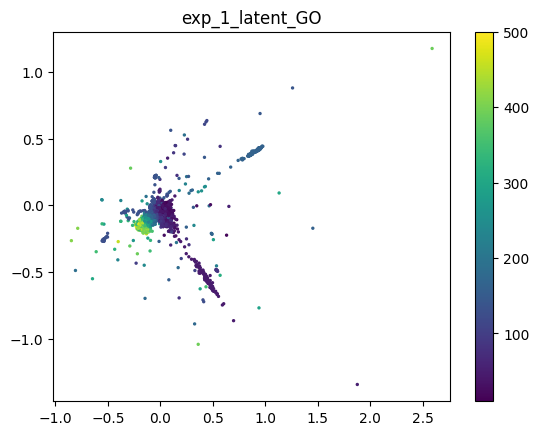

In [30]:
import matplotlib.pyplot as plt
plt.scatter(latent_coord[:, 0], latent_coord[:, 1], s = 2, c=lengths, cmap='viridis')
plt.colorbar()
plt.title('exp_1_latent_GO')
plt.savefig("exp_1_latent_GO.png")

In [75]:
plt.savefig('exp_4_latent')

<Figure size 640x480 with 0 Axes>